# Insurance Claim Prediction Notebook

Start by importing the required libraries.

In [130]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif

Import the datasets. Input data files are available in the "/dataset/.." directory.

In [131]:
train_data = pd.read_csv('dataset/train.csv')
test_data = pd.read_csv('dataset/test.csv')

# Data

In [132]:
train_data.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


Printing the shape of the dataset.

In [133]:
train_data.shape, test_data.shape

((58592, 44), (39063, 43))

The train dataset contains 58592 rows and 44 columns.
<br>
The test dataset contains 39063 rows and 43 columns.
<br>
The missing column in the test dataset is the "is_claim" attribute.

---

Check what type of data we are analysing.

In [135]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

This information shows that the dataset has no null-values.
<br>
There are 16 numerical features and 28 categorical features.

---

### Categorical Types

In [138]:
categorical = train_data.select_dtypes(include=object).columns
categorical

Index(['area_cluster', 'segment', 'fuel_type', 'engine_type', 'is_esc',
       'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
       'is_parking_camera', 'rear_brakes_type', 'transmission_type',
       'steering_type', 'is_front_fog_lights', 'is_rear_window_wiper',
       'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
       'is_power_door_locks', 'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert'],
      dtype='object')

---

### Numerical Types

In [139]:
numerical = train_data.select_dtypes(include=np.number).columns
numerical

Index(['policy_tenure', 'age_of_car', 'age_of_policyholder',
       'population_density', 'airbags', 'displacement', 'cylinder', 'gear_box',
       'turning_radius', 'length', 'width', 'height', 'gross_weight',
       'ncap_rating', 'is_claim', 'max_torque_nm', 'max_torque_rpm',
       'max_power_bhp', 'max_power_rpm'],
      dtype='object')

View the statistical summary of numerical variables.

In [134]:
train_data.describe()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,ncap_rating,is_claim
count,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.00000,58592.000000,58592.000000,58592.000000
mean,0.611246,0.069424,0.469420,18826.858667,1.763722,3.137066,1162.355851,3.626963,5.245443,4.852893,3850.476891,1672.233667,1553.33537,1385.276813,1.759950,0.063968
std,0.414156,0.056721,0.122886,17660.174792,1.136988,1.832641,266.304786,0.483616,0.430353,0.228061,311.457119,112.089135,79.62227,212.423085,1.389576,0.244698
min,0.002735,0.000000,0.288462,290.000000,1.000000,1.000000,796.000000,3.000000,5.000000,4.500000,3445.000000,1475.000000,1475.00000,1051.000000,0.000000,0.000000
25%,0.210250,0.020000,0.365385,6112.000000,1.000000,2.000000,796.000000,3.000000,5.000000,4.600000,3445.000000,1515.000000,1475.00000,1185.000000,0.000000,0.000000
50%,0.573792,0.060000,0.451923,8794.000000,1.000000,2.000000,1197.000000,4.000000,5.000000,4.800000,3845.000000,1735.000000,1530.00000,1335.000000,2.000000,0.000000
75%,1.039104,0.110000,0.548077,27003.000000,3.000000,6.000000,1493.000000,4.000000,5.000000,5.000000,3995.000000,1755.000000,1635.00000,1510.000000,3.000000,0.000000
max,1.396641,1.000000,1.000000,73430.000000,5.000000,6.000000,1498.000000,4.000000,6.000000,5.200000,4300.000000,1811.000000,1825.00000,1720.000000,5.000000,1.000000


---

In order to analyse both train and test dataset, we need to check if there are any missing values.

In [140]:
train_data.isnull().sum()

policy_tenure                       0
age_of_car                          0
age_of_policyholder                 0
area_cluster                        0
population_density                  0
segment                             0
fuel_type                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
gear_box                            0
steering_type                       0
turning_radius                      0
length                              0
width                               0
height                              0
gross_weight                        0
is_front_fog_lights                 0
is_rear_wind

Verify if there are any duplicated values.

In [141]:
train_data.duplicated().sum()

0

How many policyholders filed a claim in the last 6 months?

In [142]:
train_data.is_claim.value_counts()

0    54844
1     3748
Name: is_claim, dtype: int64

The values for the target column are imbalanced.

---

### Organize Data

Drop unnecessary columns. This columns don't add any necessary value to the analyisis.

In [137]:
train_data.drop(['policy_id','make','model'], axis=1, inplace=True)

In order to compare some data, we found it easier to divide them and create new columns.

In [136]:
train_data['max_torque_nm'] = train_data['max_torque'].str.extract(r"([-+]?[0-9]*\.?[0-9]+)(?=\s*Nm)").astype('float64')
train_data['max_torque_rpm'] = train_data['max_torque'].str.extract(r"([-+]?[0-9]*\.?[0-9]+)(?=\s*rpm)").astype('float64')
train_data['max_power_bhp'] = train_data['max_power'].str.extract(r"([-+]?[0-9]*\.?[0-9]+)(?=\s*bhp)").astype('float64')
train_data['max_power_rpm'] = train_data['max_power'].str.extract(r"([-+]?[0-9]*\.?[0-9]+)(?=\s*rpm)").astype('float64')
train_data.drop(['max_torque', 'max_power'], axis=1, inplace=True)

# Data Analysis

## Univariate Analysis

Focusing on each variable in isolation.

/var/folders/53/qc5t9ngj6wl4rtwfwwjhqcm80000gn/T/ipykernel_13701/261912381.py:9: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


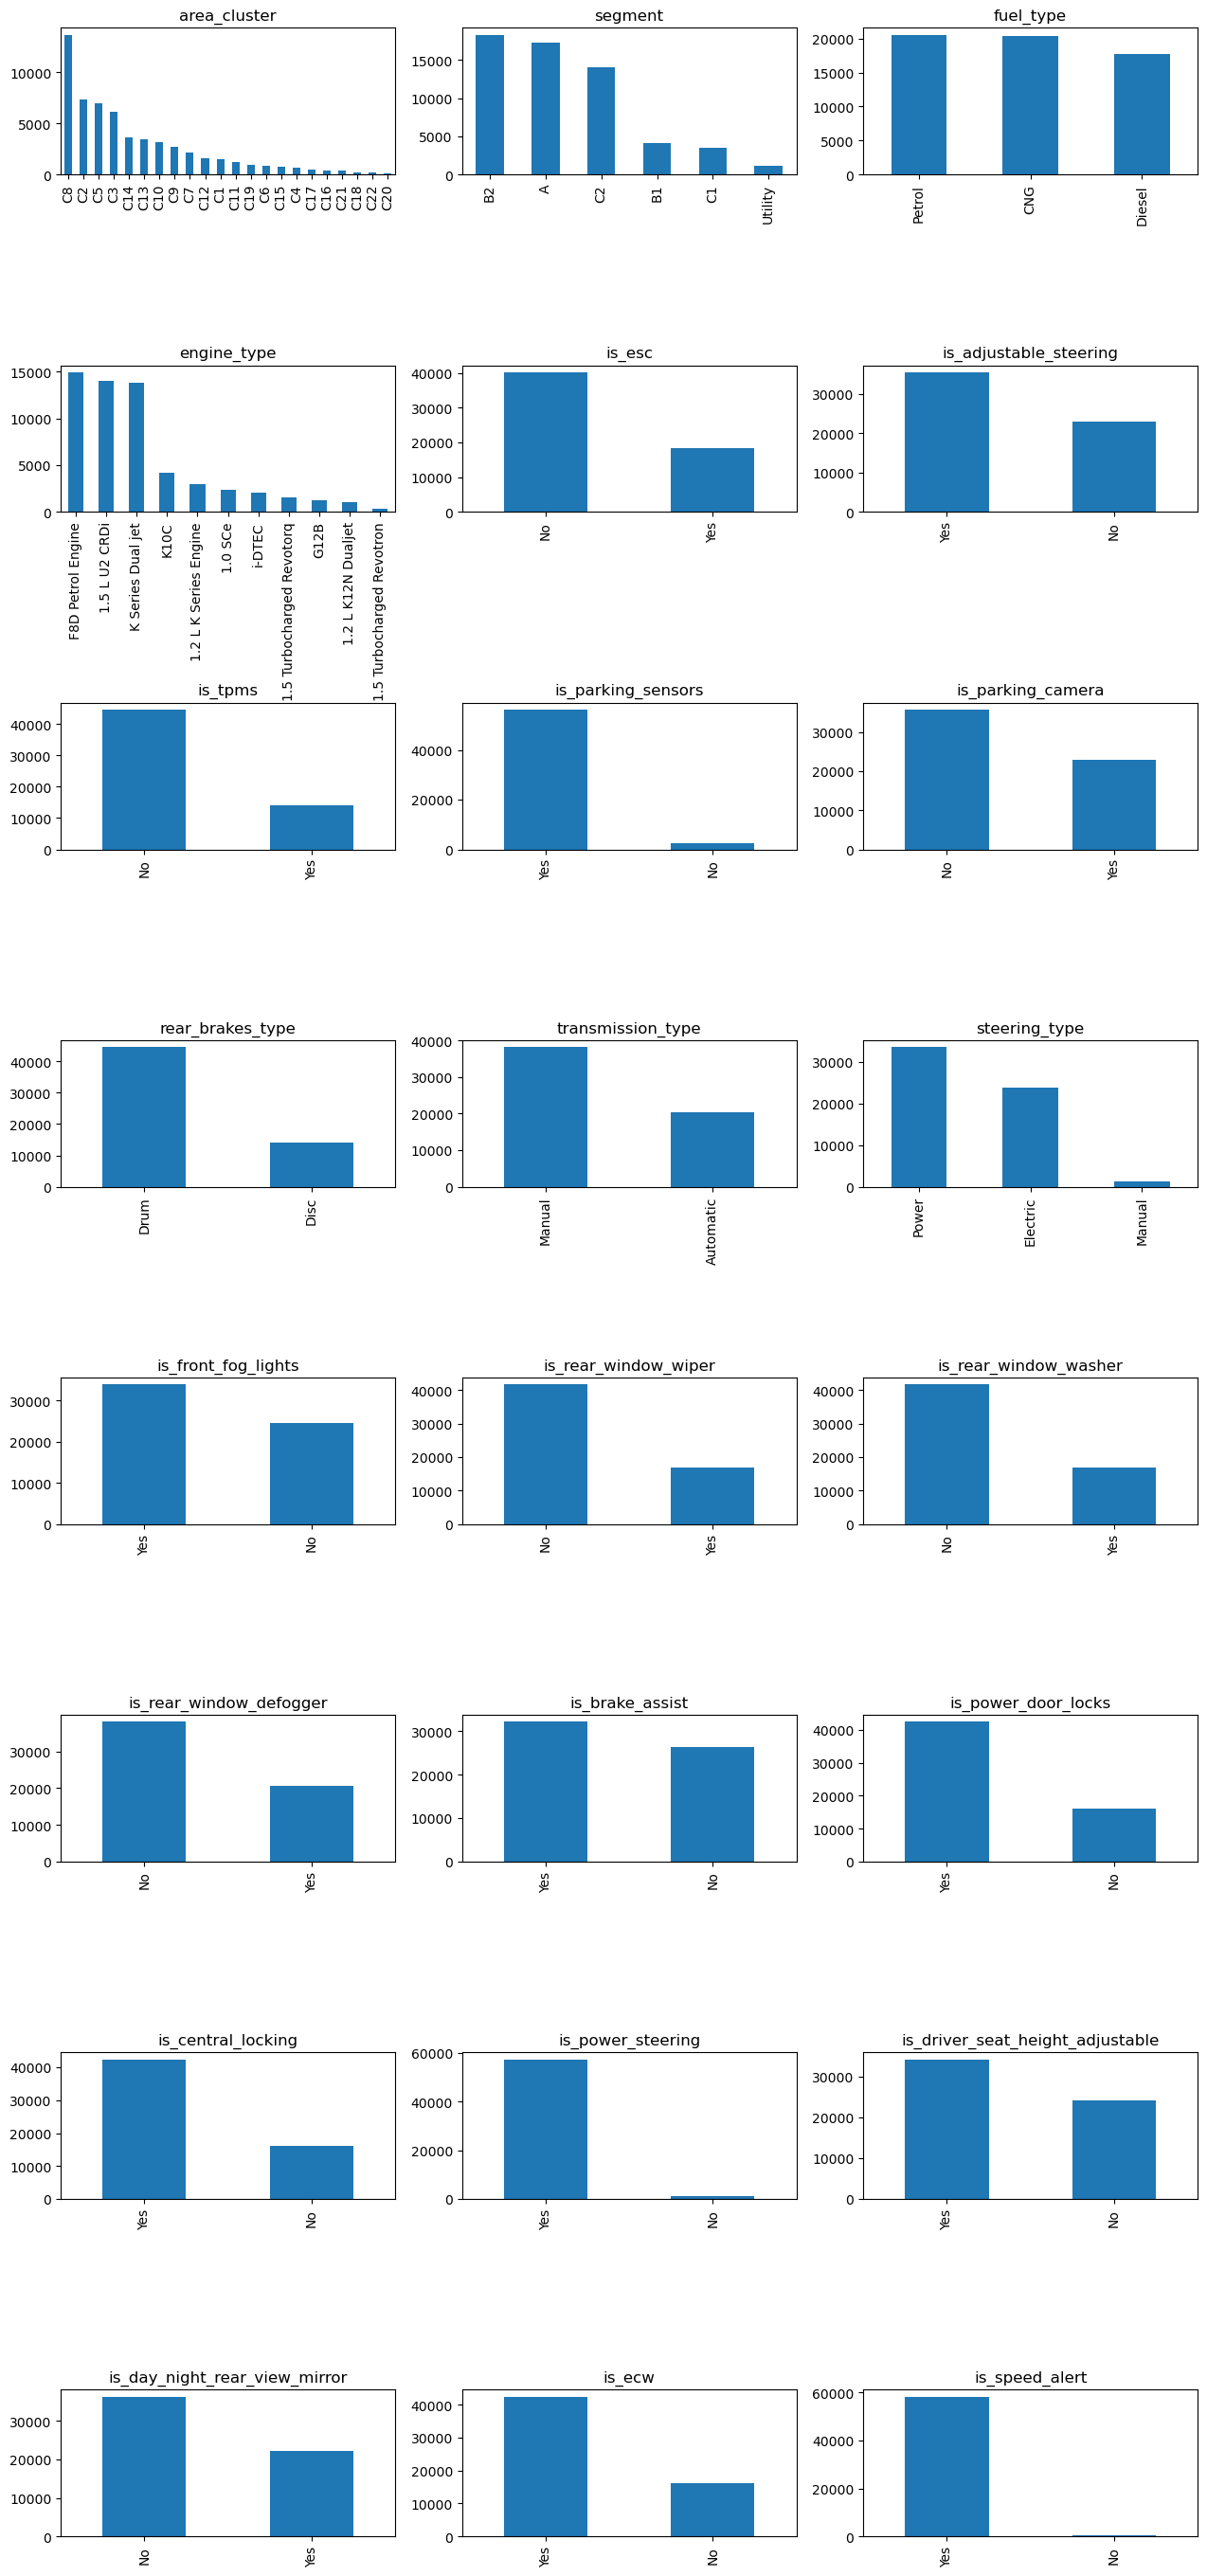

In [143]:
j=1
for i in categorical:
    plt.subplots_adjust(left=None, bottom=1, right=2,top=8, wspace=None, hspace=1.3)
    plt.subplot(10,3,j)
    train_data[i].value_counts().plot(kind='bar')
    plt.title(i)
    j+=1
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

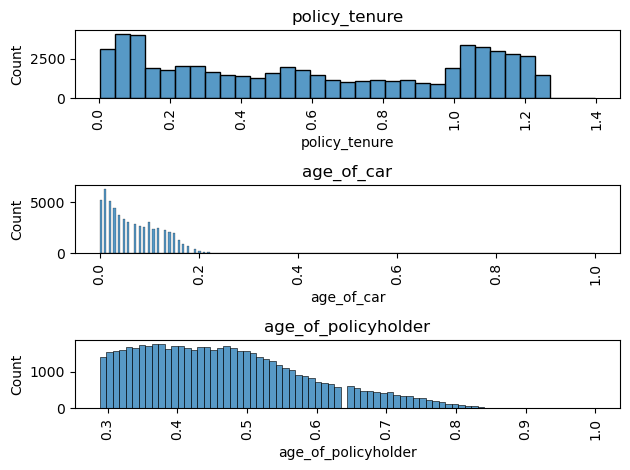

In [144]:
unidata = ['policy_tenure', 'age_of_car', 'age_of_policyholder']
j=1

for i in unidata:
    plt.subplot(3,1,j)
    sns.histplot(train_data[i])
    plt.title(i)
    j=j+1
    plt.xticks(rotation=90)
    
plt.tight_layout()    
plt.show()

## Bivariate Analysis

Comparing each variable to the is_claim column.

In [145]:
bdata = ['area_cluster', 'population_density', 'segment', 'fuel_type', 'engine_type', 'airbags',
         'rear_brakes_type', 'displacement', 'cylinder', 'transmission_type', 'gear_box', 'steering_type',
         'turning_radius', 'length', 'width', 'height', 'gross_weight', 'ncap_rating']

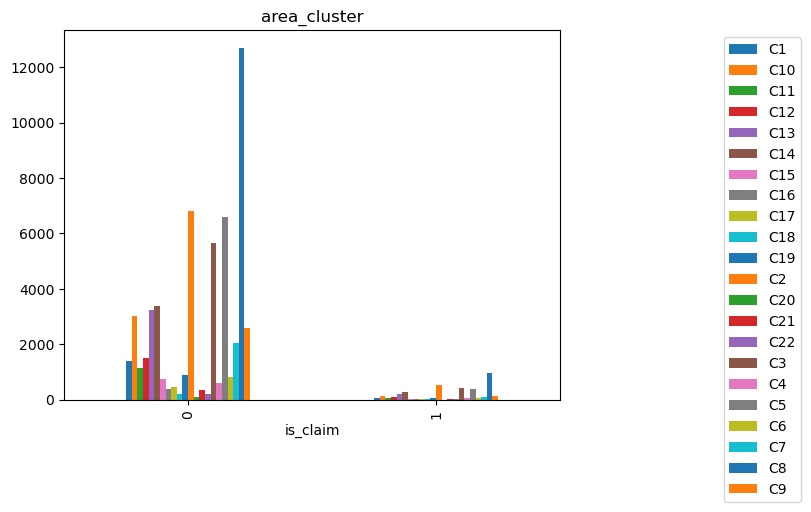

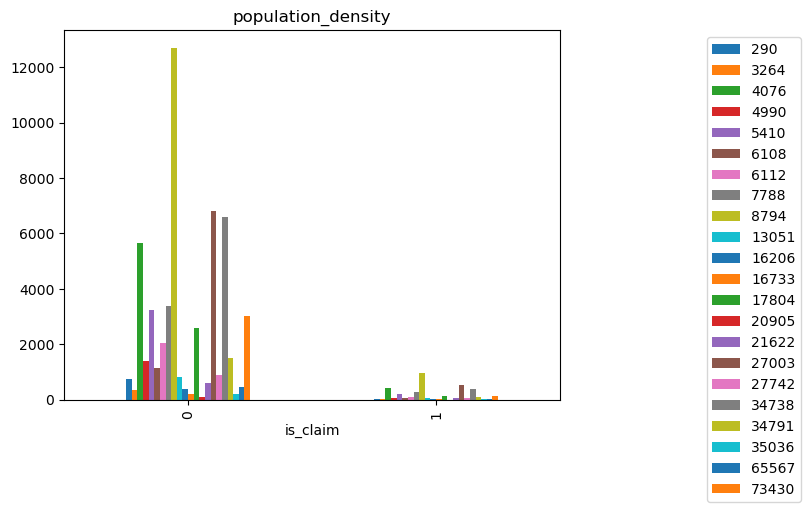

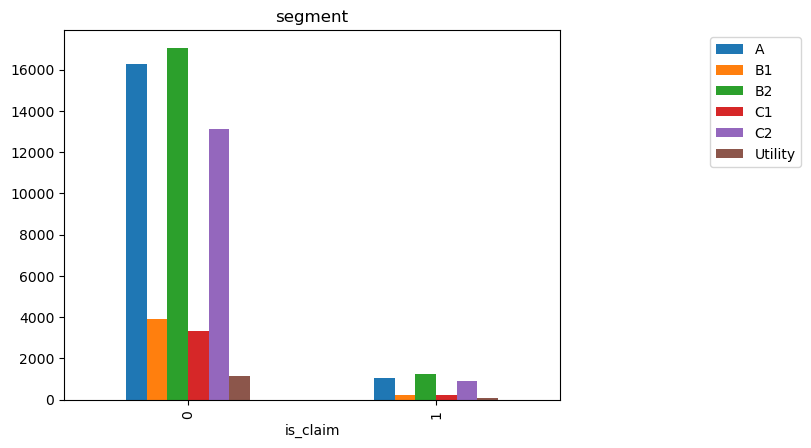

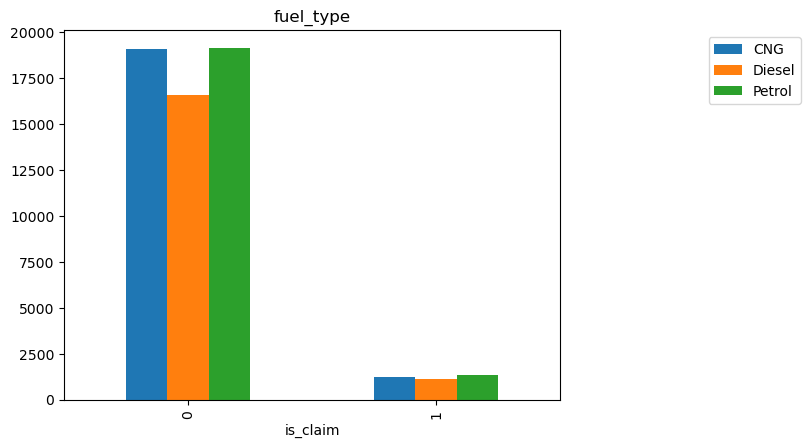

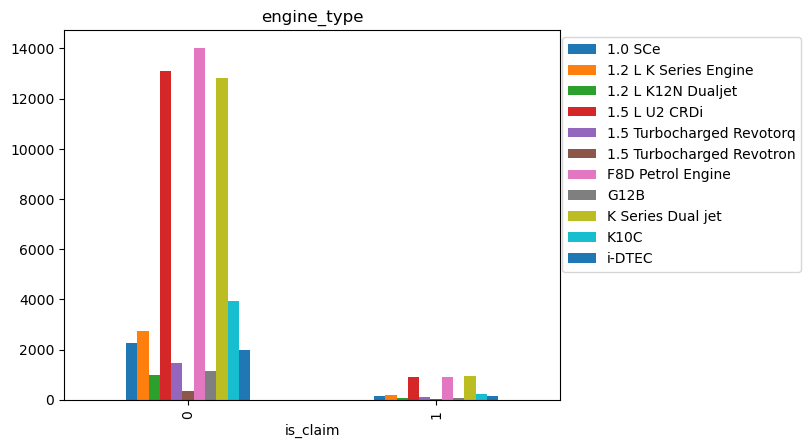

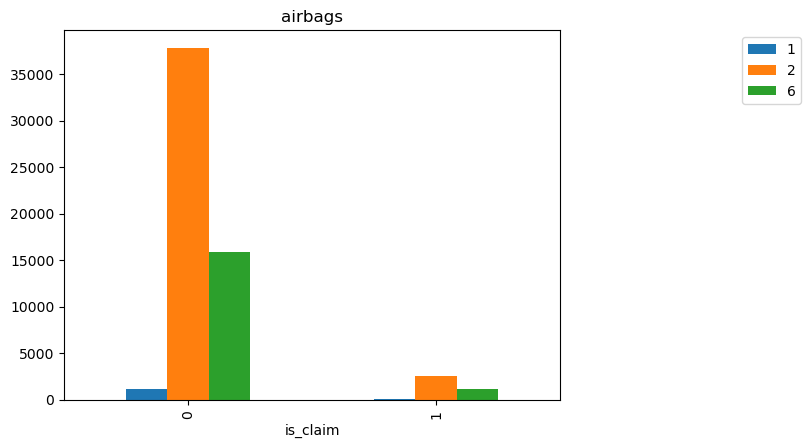

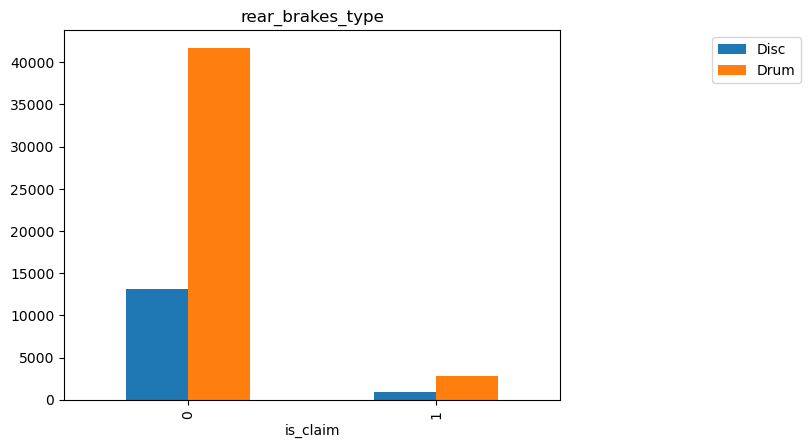

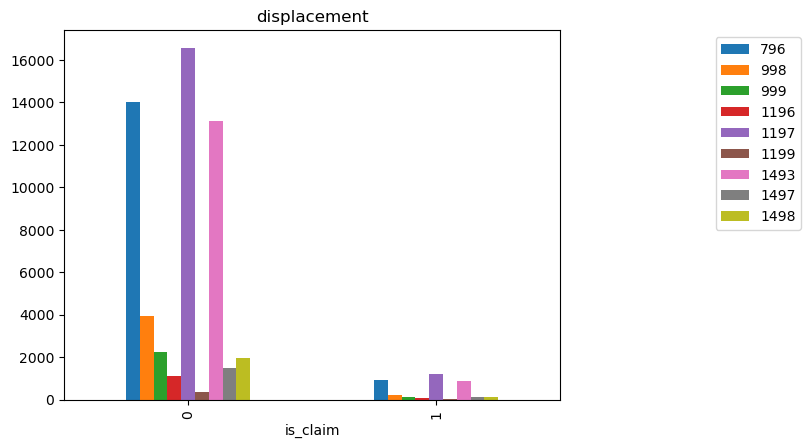

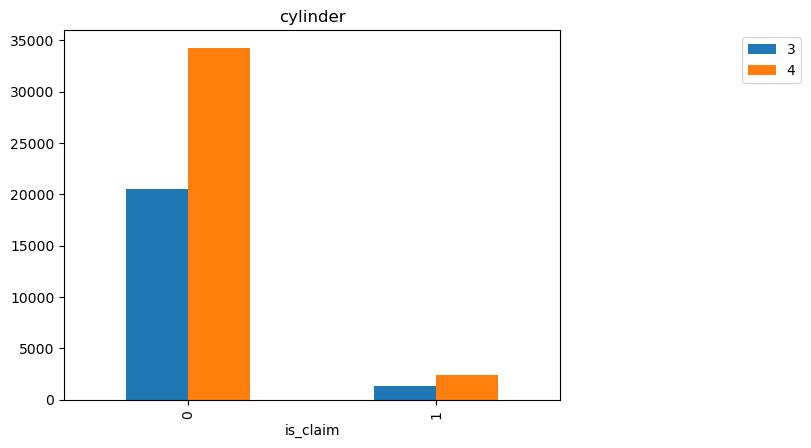

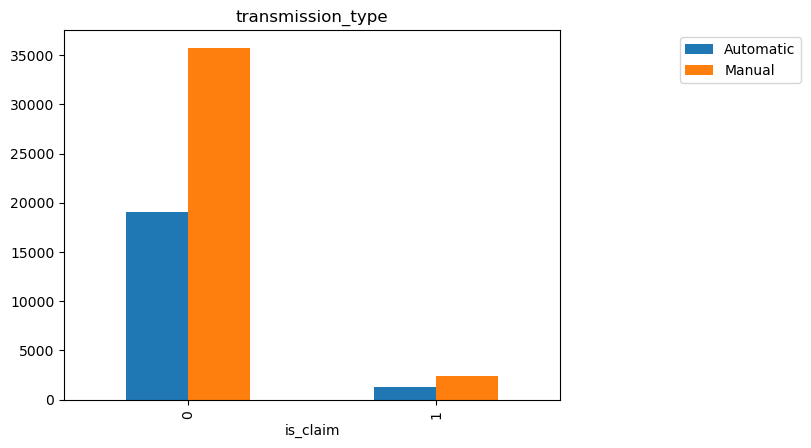

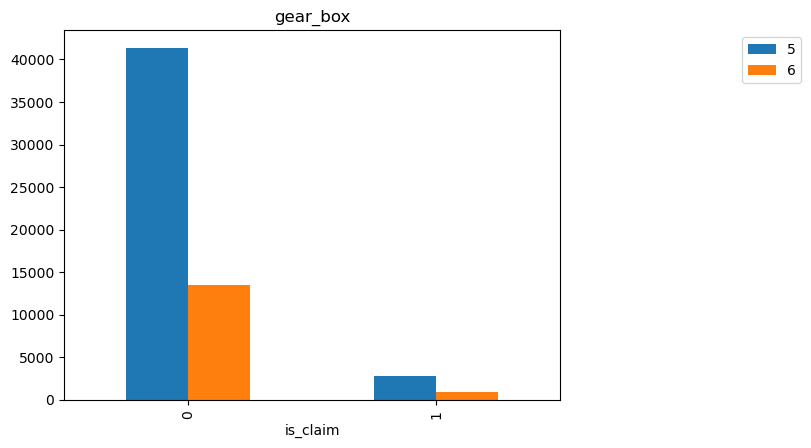

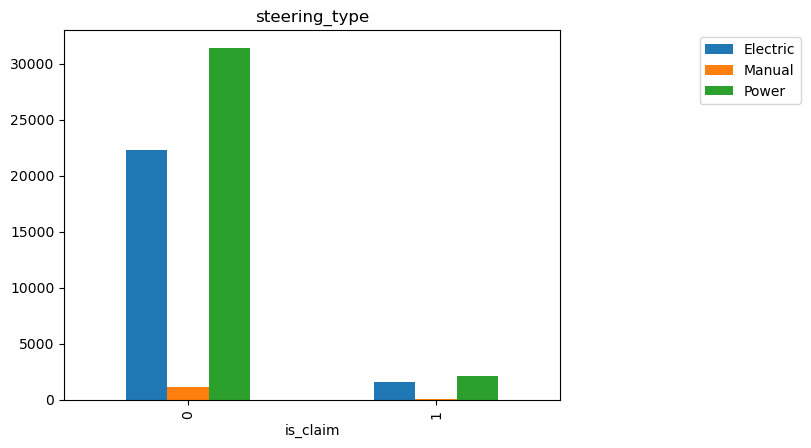

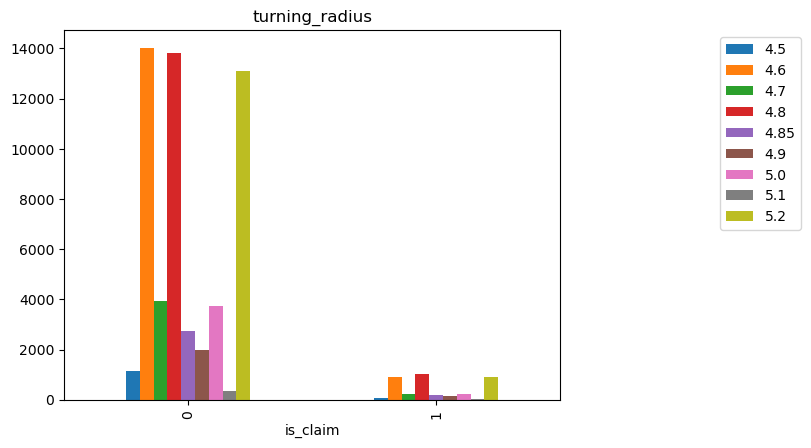

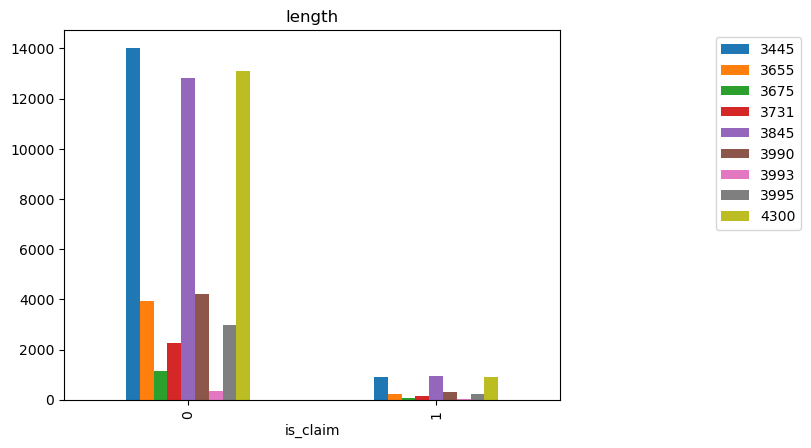

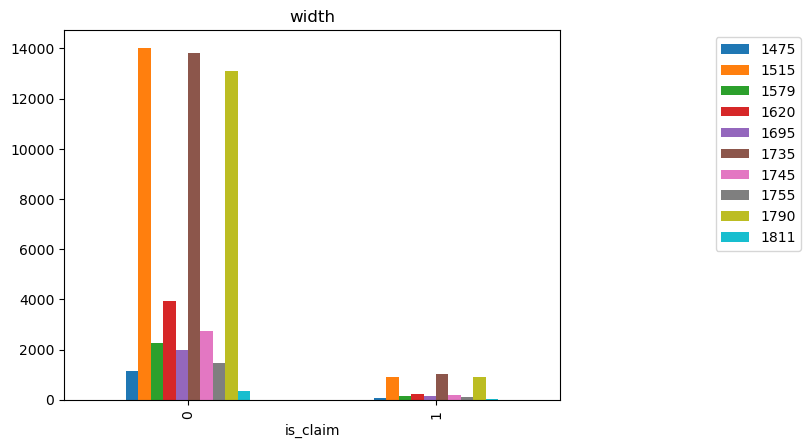

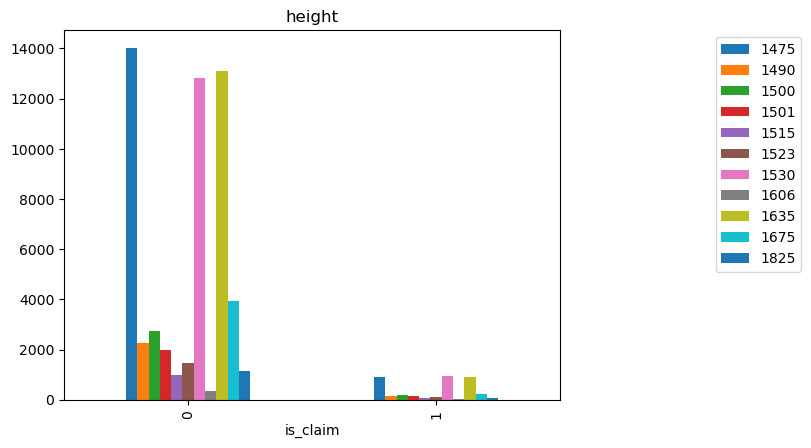

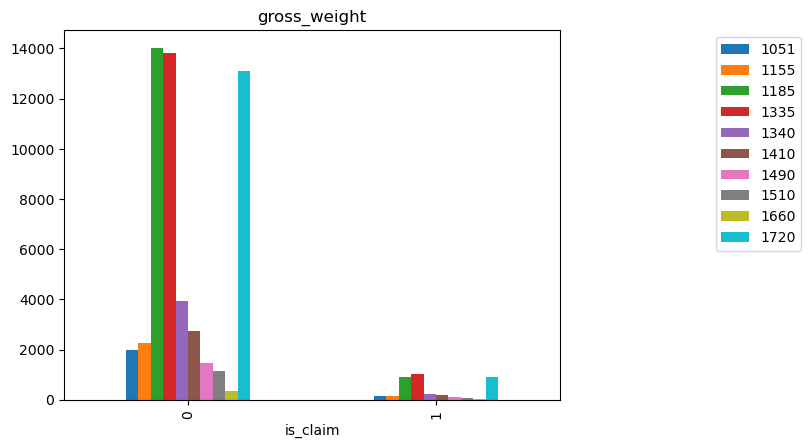

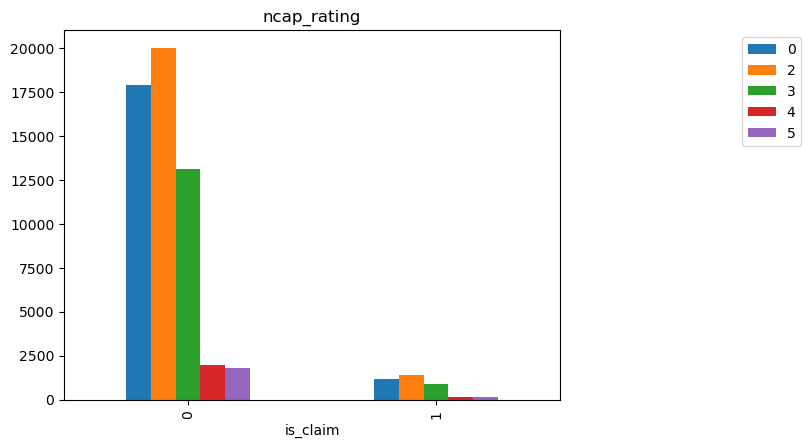

In [146]:
j=1
for i in bdata:
    pd.crosstab(train_data.is_claim, train_data[i]).plot(kind='bar')
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
    plt.title(i)
    j+=1
    plt.xticks(rotation=90)
#plt.tight_layout()    
plt.show()

## Feature Selection

In [147]:
train_data.head()

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,segment,fuel_type,engine_type,airbags,is_esc,...,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim,max_torque_nm,max_torque_rpm,max_power_bhp,max_power_rpm
0,0.515874,0.05,0.644231,C1,4990,A,CNG,F8D Petrol Engine,2,No,...,No,No,No,Yes,0,0,60.0,3500.0,40.36,6000.0
1,0.672619,0.02,0.375000,C2,27003,A,CNG,F8D Petrol Engine,2,No,...,No,No,No,Yes,0,0,60.0,3500.0,40.36,6000.0
2,0.841110,0.02,0.384615,C3,4076,A,CNG,F8D Petrol Engine,2,No,...,No,No,No,Yes,0,0,60.0,3500.0,40.36,6000.0
3,0.900277,0.11,0.432692,C4,21622,C1,Petrol,1.2 L K12N Dualjet,2,Yes,...,Yes,Yes,Yes,Yes,2,0,113.0,4400.0,88.50,6000.0
4,0.596403,0.11,0.634615,C5,34738,A,Petrol,1.0 SCe,2,No,...,No,Yes,Yes,Yes,2,0,91.0,4250.0,67.06,5500.0


In order to analyse some data, some values need to be normalized, such as 'area_cluster' and 'engine_type'.

In [148]:
cluster_freq = train_data['area_cluster'].value_counts(normalize=True).to_dict()
train_data['area_cluster'] = train_data['area_cluster'].map(cluster_freq)

engine_freq = train_data['engine_type'].value_counts(normalize=True).to_dict()
train_data['engine_type'] = train_data['engine_type'].map(engine_freq)

In [149]:
data = pd.get_dummies(data=train_data,columns=['segment', 'fuel_type', 'airbags', 'is_esc', 'is_adjustable_steering',
       'is_tpms', 'is_parking_sensors', 'is_parking_camera',
       'rear_brakes_type', 'cylinder', 'transmission_type', 'gear_box',
       'steering_type', 'is_front_fog_lights', 'is_rear_window_wiper',
       'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
       'is_power_door_locks', 'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert', 'ncap_rating'],drop_first=True)

data.head(2)

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,engine_type,displacement,turning_radius,length,width,...,is_central_locking_Yes,is_power_steering_Yes,is_driver_seat_height_adjustable_Yes,is_day_night_rear_view_mirror_Yes,is_ecw_Yes,is_speed_alert_Yes,ncap_rating_2,ncap_rating_3,ncap_rating_4,ncap_rating_5
0,0.515874,0.05,0.644231,0.025055,4990,0.25512,796,4.6,3445,1515,...,0,1,0,0,0,1,0,0,0,0
1,0.672619,0.02,0.375000,0.125307,27003,0.25512,796,4.6,3445,1515,...,0,1,0,0,0,1,0,0,0,0


Split the training dataset into features (x) and the target variable (y).

In [150]:
x = data.drop('is_claim', axis=1)
y = data['is_claim']

In [152]:
mutual = mutual_info_classif(x,y)
mutual = pd.Series(mutual)
mutual.index = x.columns
pd.DataFrame(mutual.sort_values(ascending=True), columns=['Mutual information']).head(20)

,Mutual information
ncap_rating_5,0.000000
segment_Utility,0.000000
ncap_rating_4,0.000000
steering_type_Manual,0.000000
segment_C1,0.000000
age_of_policyholder,0.000000
segment_B1,0.001096
segment_C2,0.001118
gear_box_6,0.001310
ncap_rating_3,0.001329
